In [1]:
import os
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from sklearn.metrics import (mean_squared_error as mse, 
                            mean_absolute_error as mae,
                            r2_score)
from sklearn.model_selection import (RepeatedStratifiedKFold as RSKF, 
                                     StratifiedKFold as SKF,
                                     KFold, 
                                     RepeatedKFold as RKF, 
                                     cross_val_score)
from sklearn.ensemble import (RandomForestRegressor as RFR,
                              ExtraTreesRegressor as ETR,
                              GradientBoostingRegressor as GBR,
                              HistGradientBoostingRegressor as HGBR
                             )
from sklearn.linear_model import Ridge, Lasso

import plotly.express as px
from tqdm.autonotebook import tqdm
from IPython.display import display, HTML

# %load_ext autoreload
# %autoreload 2
np.random.seed(42)
tqdm.pandas()

/var/folders/8p/5_r5jcmx2sl549t8tgwqvr3c0000gn/T/ipykernel_17019/3527458239.py:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def format_plot(
    fig, 
    legends = None, 
    xlabel="Time", 
    ylabel="Value", 
    figsize=(500,900), 
    font_size=15, 
    title_font_size=20
):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t:  t.update(name = next(names)))
    fig.update_layout(
            autosize=False,
            width=figsize[1],
            height=figsize[0],
            title={
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            titlefont={
                "size": 20
            },
            legend_title = None,
            legend=dict(
                font=dict(size=font_size),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                title_text=ylabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            ),
            xaxis=dict(
                title_text=xlabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            )
        )
    return fig

In [3]:
preprocessed = Path("Data/processed/")

In [4]:
train_df = pd.read_parquet(preprocessed/"engineered_train.parquet")
test_df = pd.read_parquet(preprocessed/"engineered_test.parquet")
print(train_df.shape)
print(test_df.shape)
train_df.head()

(866, 52)
(134, 52)


,treatment_company,azimuth,md (ft),tvd (ft),operator,footage lateral length,well spacing,porpoise deviation,porpoise count,shale footage,...,std_year_op_proppant volume,skew_year_op_proppant volume,min_year_op_youngs modulus,max_year_op_youngs modulus,std_year_op_youngs modulus,skew_year_op_youngs modulus,min_year_op_p-velocity,max_year_op_p-velocity,std_year_op_p-velocity,skew_year_op_p-velocity
0,1,-14.430,14404,6437.000,1,7020.000,1152.576,34.400,9,0,...,4264601.167,0.499,28.120,31.170,1.397,0.017,12290.630,13595.400,546.589,0.335
1,1,-16.320,10535,6035.000,1,4343.000,1852.010,6.960,3,0,...,1633163.174,1.734,25.930,31.070,2.142,-0.512,12070.110,13593.930,536.128,-0.843
2,8,-31.371,15111,6318.000,1,8372.000,2362.482,41.960,15,10042,...,1633163.174,1.734,25.930,31.070,2.142,-0.512,12070.110,13593.930,536.128,-0.843
3,1,-48.480,12667,6714.000,1,5529.000,1052.818,10.640,3,2575,...,4406462.698,2.322,28.310,31.140,1.080,-1.225,12230.700,13591.620,412.831,-0.994
4,1,-28.690,12606,6832.000,1,5121.000,902.851,46.200,6,0,...,4406462.698,2.322,28.310,31.140,1.080,-1.225,12230.700,13591.620,412.831,-0.994


In [5]:
X_train = train_df.drop(["production","treatment_company"], axis = 1)
y_train = train_df.production
X_test = test_df.drop(["production","treatment_company"], axis = 1)
y_test = test_df.production

In [6]:
dispatcher = \
{'RFR': RFR(**{
    'n_estimators': 4000,
    'criterion': 'squared_error',
    'max_depth': 3,
    'max_features':"sqrt",
    'min_samples_leaf': 12,
    'random_state': 42,
    'n_jobs': -1
        }
    ),
 
 'GBR' : GBR(**{'loss': 'squared_error',
                'learning_rate': 0.065,
                'n_estimators': 4000,
                'min_samples_leaf': 25,
                'max_depth': 5,
                'random_state': 42,
                'alpha': 0.65,
                'n_iter_no_change': 180,
                'tol': 0.0001, 
              }
           ),
 
 'HGBR': HGBR(**{'loss':'squared_error',
                 'l2_regularization': 0.825,
                 'learning_rate': 0.065,
                 'max_depth': 8,
                 'min_samples_leaf': 36,
                 'n_iter_no_change': 220,
                 'tol': 1e-04,
                 'verbose': 0,
                 'random_state': 42,
                }
             )
}

# Initializing output tables for the models
methods = list(dispatcher.keys())
# OOF_Preds = pd.DataFrame(columns = methods)
Scores = pd.DataFrame(columns = methods, index = ["rmse","mae"])

In [7]:
# Training with KFold
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize an empty list to store validation metrics
validation_rmse = []
validation_mae = []

def Train(method, importances = False):
    # Iterate over the folds
    model = dispatcher.get(method)
    for train_index, val_index in kf.split(X_train):
        # Split the training data further into training and validation sets
        X_train_fold, X_val_fold = X_train.loc[train_index], X_train.loc[val_index]
        y_train_fold, y_val_fold = y_train.loc[train_index], y_train.loc[val_index]
        
        # Train a model on the training fold
        model.fit(X_train_fold, y_train_fold)
        
        # Evaluate the model on the validation fold
        y_val_pred = model.predict(X_val_fold)
        val_rmse = np.sqrt(mse(y_val_fold, y_val_pred))
        val_mae = mae(y_val_fold, y_val_pred)
        
        # Store the validation metrics
        validation_rmse.append(val_rmse)
        validation_mae.append(val_mae)

    # Calculate the average validation metrics
    avg_val_rmse = sum(validation_rmse) / len(validation_rmse)
    avg_val_mae = sum(validation_mae) / len(validation_mae)

    Scores[method].loc["rmse"] = avg_val_rmse
    Scores[method].loc["mae"] = avg_val_mae

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for method in tqdm(methods):
        Train(method)

  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
Scores

,RFR,GBR,HGBR
rmse,986.538,898.494,862.423
mae,694.951,618.277,590.662


# Inference on test set

In [18]:
best_model_score = Scores.loc["rmse"].sort_values().index[0]

In [19]:
# Evaluate the model on the test set
top_model = dispatcher.get(best_model_score)
y_test_pred = top_model.predict(X_test)
test_rmse = np.sqrt(mse(y_test, y_test_pred))
print("Test RMSE:", test_rmse)

Test RMSE: 869.3588941696269


# plotting test predictions vs original

In [20]:
y_test_pred = pd.Series(y_test_pred, name = "predicted production")
pd.concat([y_test,pd.Series(y_test_pred)], axis = 1).sample(10)

,production,predicted production
30,2247.647,1822.160
133,1010.514,658.078
39,2091.469,1903.460
49,2903.932,2548.716
63,369.433,749.842
106,4841.057,4274.775
13,1466.347,1766.044
103,778.601,719.289
9,2433.941,2118.446
53,1828.091,1648.452


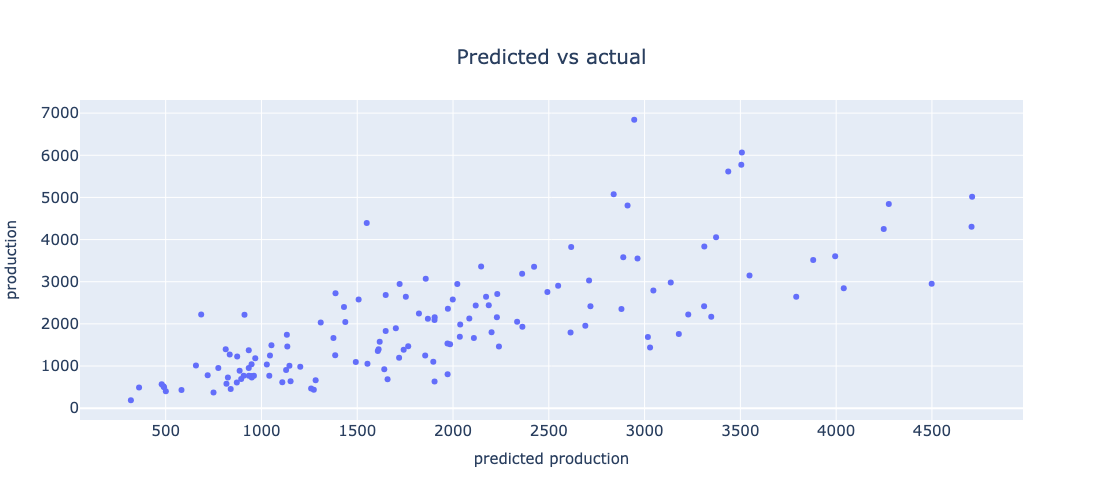

In [21]:
plot_df = pd.concat([y_test,y_test_pred], axis = 1)
plot_df["Diff"] = plot_df["predicted production"]-plot_df["production"]
score_list = []
for i in plot_df["Diff"]:
    if i > -500 and i < 500:
        score_list.append(1)
    elif i > -900 and i < 900:
        score_list.append(2)
    else:
        score_list.append(3)
plot_df["Score"] = score_list

fig = px.scatter(
    plot_df, 
    y="production", 
    x="predicted production",
    title=f"Predicted vs actual"
)
fig = format_plot(fig, ylabel="production", xlabel="predicted production", legends=False)
fig.update_layout(showlegend=False) 
fig.show()

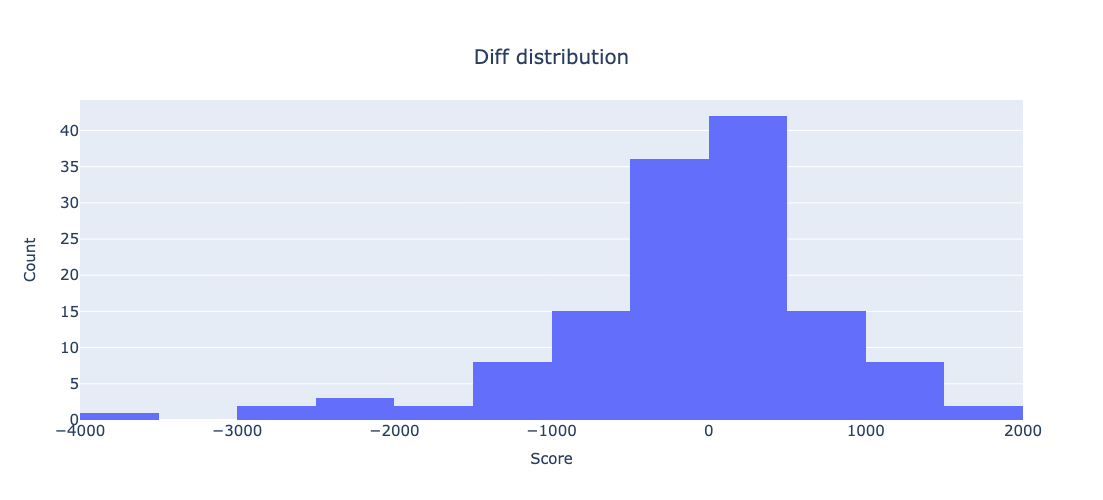

In [22]:
fig = px.histogram(
    plot_df["Diff"],
    title=f"Diff distribution"
)
fig = format_plot(fig, ylabel="Count", xlabel="Score", legends=False)
fig.update_layout(showlegend=False) 
fig.show()

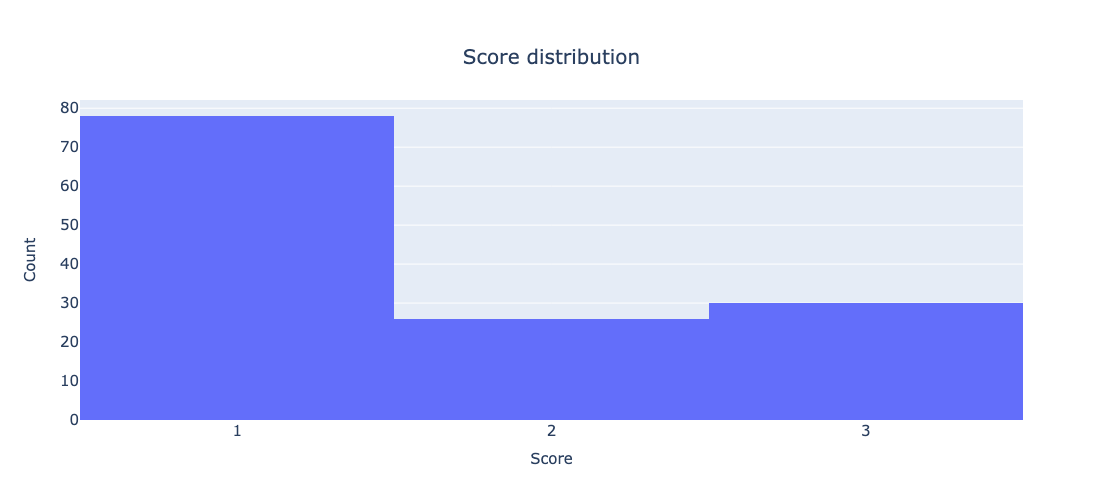

In [23]:
fig = px.histogram(
    plot_df["Score"],
    title=f"Score distribution",
    nbins = 3
)
fig = format_plot(fig, ylabel="Count", xlabel="Score", legends=False)
fig.update_layout(showlegend=False) 
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [1,2,3]
    )
)
fig.show()

# Feature Importance

In [24]:
gbr_model = dispatcher.get("GBR")
feature_importances = gbr_model.feature_importances_

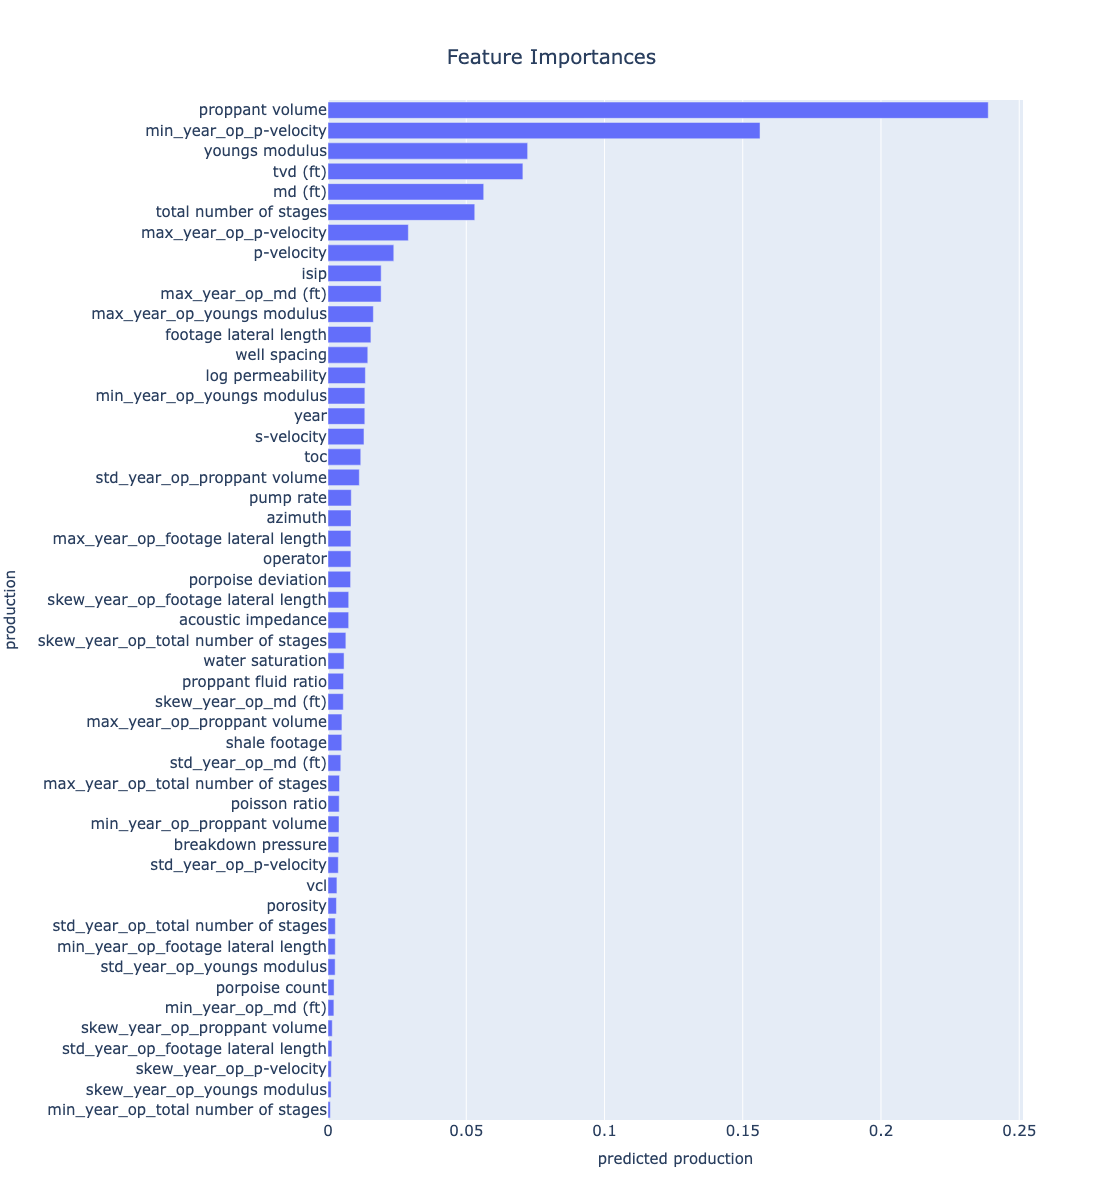

In [25]:
# Get feature importances
importances = pd.Series(feature_importances, name = "importances")
features = pd.Series(X_train.columns, name = "features")
plot_df = pd.concat([features,importances], axis = 1)
plot_df = plot_df.sort_values("importances")
fig = px.bar(
    plot_df, 
    y="features", 
    x="importances",
    title=f"Feature Importances",
    orientation='h'
)
fig = format_plot(fig, ylabel="production", xlabel="predicted production", legends=False, figsize = (1200,1000))
fig.update_layout(showlegend=False) 
fig.show()

In [26]:
y_train.describe().T

count    866.000
mean    1937.812
std     1354.896
min       76.107
25%     1004.508
50%     1544.645
75%     2591.449
max     8880.671
Name: production, dtype: float64

# Observations & Next steps

**Observations**
1. The predicted vs actual plot shows that although the model generalizes relatively well most values, there a couple of observation where the difference is significant and follows the skewed distribution of the production in the dataset
2. Some engineered features held high importance when training
3. Test RMSE was of 869 meaning that, on average, the deviation from the actual values is of 869, high difference between predicted and actual values inflates the metric

**Next Steps**
1. Construct more engineered columns. domain knowledge may help creating some high quality new features
2. Better feature selection. If more features are constructed, dimensionality may come as a burden so better feature selection methods may come handy and even use dimensionality reduction techniques
3. Algorithm selection. Try more algorithms, make use of more models to assess performance, try more robust algorithms like catboost or xgboost and do hyper parameter optimization.
4. Try to get more data if possible. More data will help the model generalize better to uncommon observations.
5. Re-train with better model on the whole train set after evaluating cross-validation results.